In [2]:
!pip install keras
!pip install keras_tuner
!pip install tensorflow
!pip install scikeras
!pip install seaborn

In [12]:
#Important librabies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, f1_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor, plot_importance


Bioinformatics part
1.   Velvet
2.   Prodigal
3.   Blast file preprocessing



In [ ]:
#1---------------
'''
velveth output 31 -shortPaired -fastq L_monocytogenes_03EB210LM_1_R1.fastq  -fastq L_monocytogenes_03EB210LM_1_R2.fastq
'''

#2---------------
'''
prodigal -i contigs.fa -a output_protein_file -d output_nucleotide_file -f gff
'''

#3---------------
import pandas as pd

# Function to parse the protein file and map each node to its sequence
def parse_protein_file(protein_file_path):
    node_sequences = {}
    current_node = None
    current_sequence = []

    with open(protein_file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # This is a new node header
                # Save the previous node and its sequence if exists
                if current_node:
                    node_sequences[current_node] = ''.join(current_sequence)
                # Extract the node name from the header
                current_node = line.split(' ')[0][1:]  # Removes '>' and trailing info
                current_sequence = []  # Reset sequence for the new node
            else:
                current_sequence.append(line)  # Add to the current sequence

        # Add the last node after finishing the loop
        if current_node:
            node_sequences[current_node] = ''.join(current_sequence)

    return node_sequences

# Parse the CSV file to get the list of nodes to extract
def extract_nodes_from_csv(csv_data):
    node_list = []
    for locations in csv_data['Unnamed: 3'][2:]:  # Skip headers and start from data rows
        if pd.notna(locations):
            # Split multiple locations by ";"
            nodes = locations.split(';')
            node_list.extend([node.strip() for node in nodes if node.strip()])
    return node_list

# Extract the sequences of the required nodes and save to a new file
def extract_sequences_for_nodes(node_sequences, node_list, output_file_path):
    with open(output_file_path, 'w') as output_file:
        for node in node_list:
            if node in node_sequences:
                output_file.write(f'>{node}\n{node_sequences[node]}\n')

# Load the CSV file
csv_file_path = '/content/VFDB_Dec_24-4420904943.csv'
csv_data = pd.read_csv(csv_file_path)

# Define file paths
protein_file_path = "/content/ERS1375118_protein_file"
output_file_path = '/content/untitled'

# Execute the extraction process
node_sequences = parse_protein_file(protein_file_path)  # Parse protein file to get sequences
node_list = extract_nodes_from_csv(csv_data)  # Extract nodes list from CSV
extract_sequences_for_nodes(node_sequences, node_list, output_file_path)  # Save to output file

FINAL DATA file loading

In [5]:
# Load the dataset
data = pd.read_csv('/content/FINAL_DATA.csv')
data = data.drop('Strain', axis=1)

# Input (features) and output (target)
X = data.drop('Food Frequency', axis=1)
y = data['Food Frequency']

Feature Selection and Extraction
1. Frequency ratio
2. Percent of unique values
3. Minmax normalizer
4. PCA And train, test split
5. Heatmap


            Column  Frequency Ratio
0             dltA         2.923077
1             fbpA         2.031250
2              ami         1.521739
3             inlF         3.238095
4             inlJ         2.307692
5              lap         7.812500
6             lapB         1.065217
7              bsh         2.450000
8              mpl         1.062500
9             plcB         2.500000
10            plcA         2.050000
11             stp         1.810811
12            inlC         1.155172
13            inlK         2.600000
14            lntA         1.176471
15           lplA1         5.952381
16            oppA         8.705882
17           prsA2         2.138889
18             hpt         1.315789
19             aut         5.272727
20        iap/cwhA         3.375000
21            gtcA         7.812500
22            inlA         1.045455
23            inlB         2.833333
24            inlP         1.150000
25            lpeA         3.000000
26             vip         2

<Axes: >

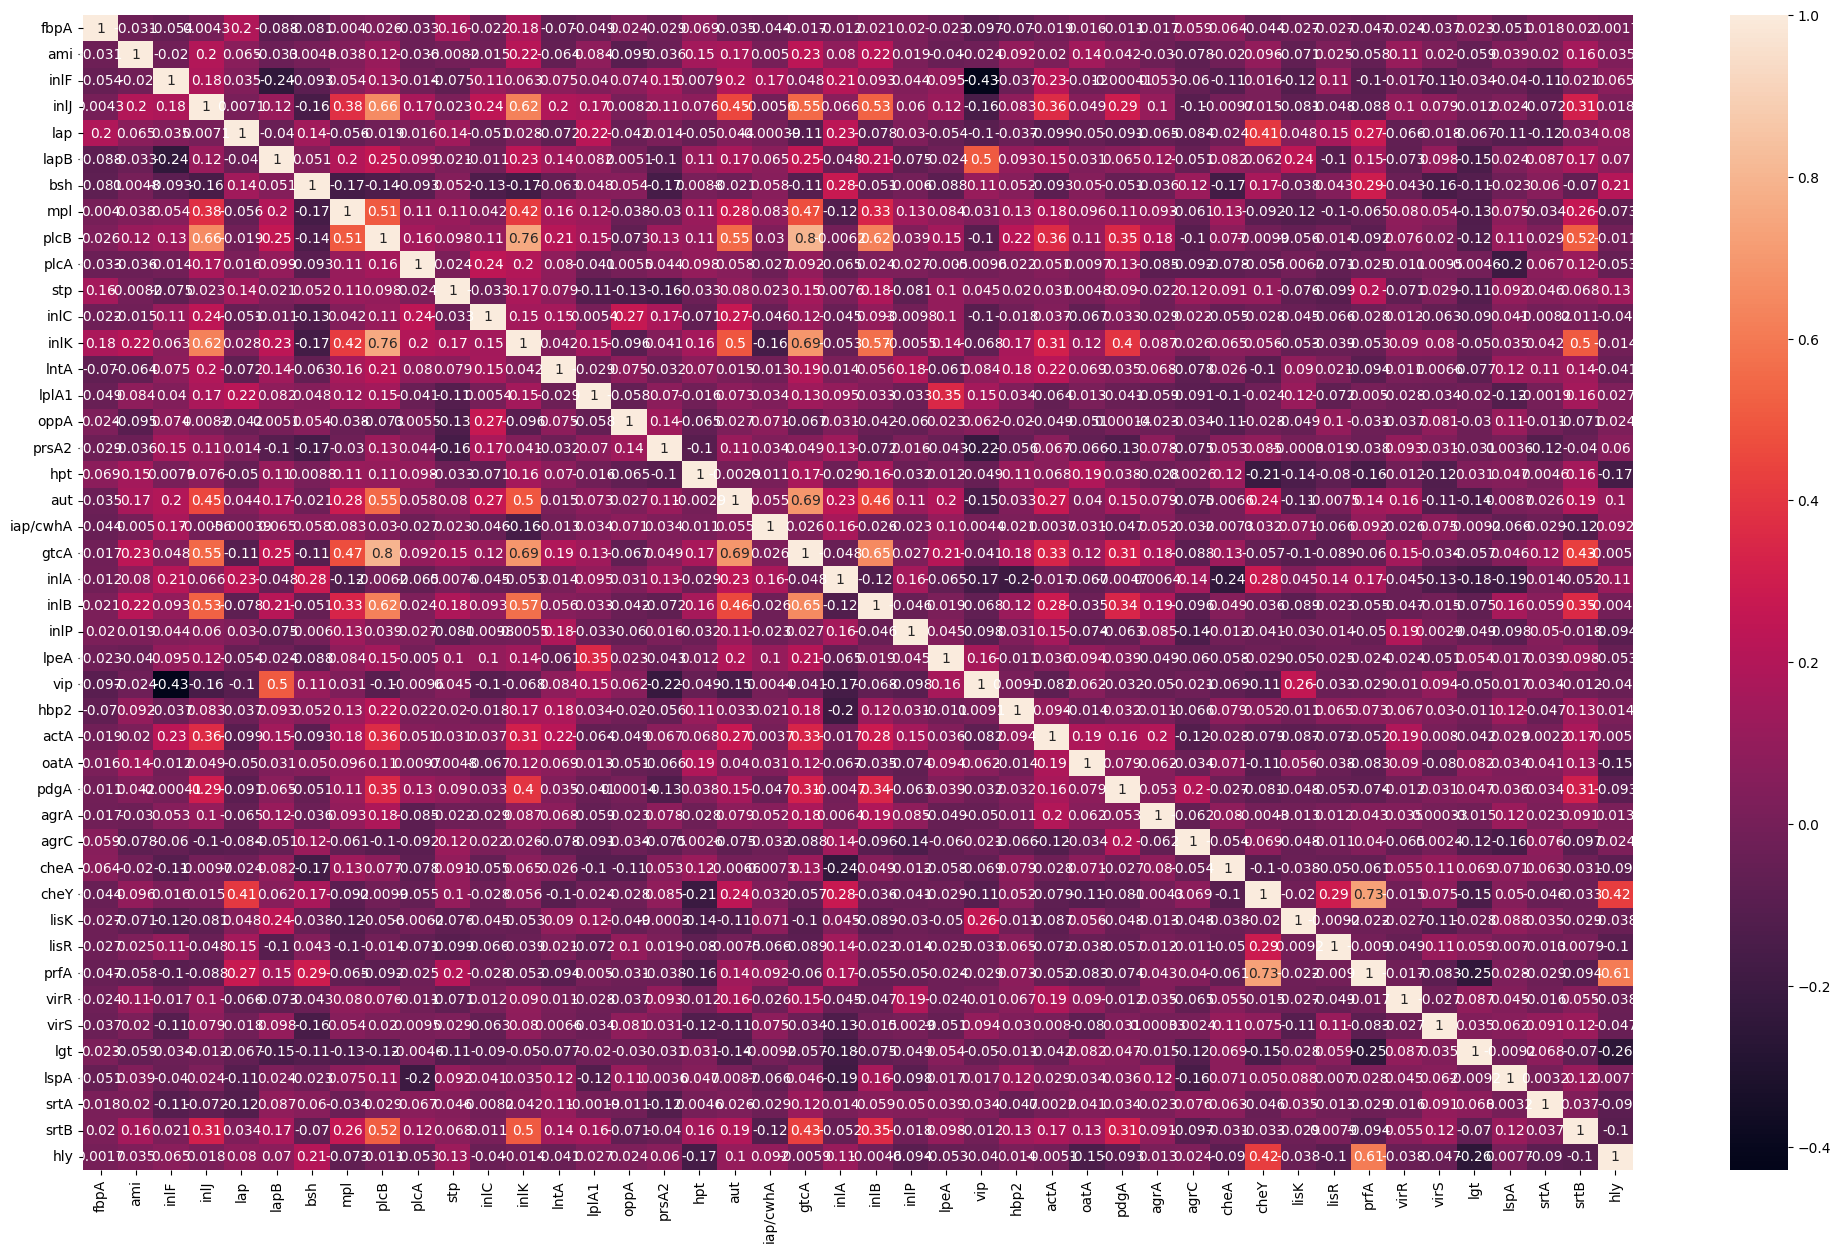

In [16]:
#1------------------------------------------------------------------------------------------ Frequency Ratio
def calculate_frequency_ratio(column):
    frequencies = column.value_counts()
    if len(frequencies) < 2:
        return None
    # Calculate the ratio of the most frequent to the second most frequent
    return frequencies.iloc[0] / frequencies.iloc[1]

# Apply the function to each column
frequency_ratios = {}
for col in data.columns:
    if col not in ['Strain']:  # Exclude non-relevant columns non num
        frequency_ratios[col] = calculate_frequency_ratio(data[col])

# Convert the results into a DataFrame
frequency_ratios_df = pd.DataFrame.from_dict(frequency_ratios, orient='index', columns=['Frequency Ratio'])
frequency_ratios_df.reset_index(inplace=True)
frequency_ratios_df.rename(columns={'index': 'Column'}, inplace=True)

# Print the frequency ratios table
print(frequency_ratios_df)

# Save the frequency ratios table to a CSV file
output_file_path = 'Frequency_Ratios.csv'
frequency_ratios_df.to_csv(output_file_path, index=False)

print(f"The table has been saved as 'Frequency_Ratios.csv' at: {output_file_path}")


#2---------------------------------------------------------------------------------Percent of unique Values

percent_unique=data.nunique()/len(data)*100
results=percent_unique.reset_index()
results.columns=['Column_name','percent']
results.to_csv('percent_unique_values.csv',index=False)

# Normalize the input data using MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

#4---------------------------------------------------------------------------------------------------PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=5) #change n-components
x_pca = pca.fit_transform(x_scaled)

# Splitting data into training and testing datasets
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=0.3, random_state=0) #Change 'x_pca' into 'x_scaled' and vice versa to change train split between split using PCA or all features

#
df = data.iloc[:, 1:-1]
CorrMat = df.corr()

plt.figure(figsize = (25,15))

sns.heatmap(CorrMat, annot=True)


**models**
1. SKI-learn models
2. NN Hyperparameters tuning
3. XGBoost
4. XGBoost vs NN

In [ ]:
#1------------------------------------------------SKI-learn models







1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

<ipython-input-22-a55858a1adde>:83: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', color='black', linewidth=2, label='Perfect Prediction')


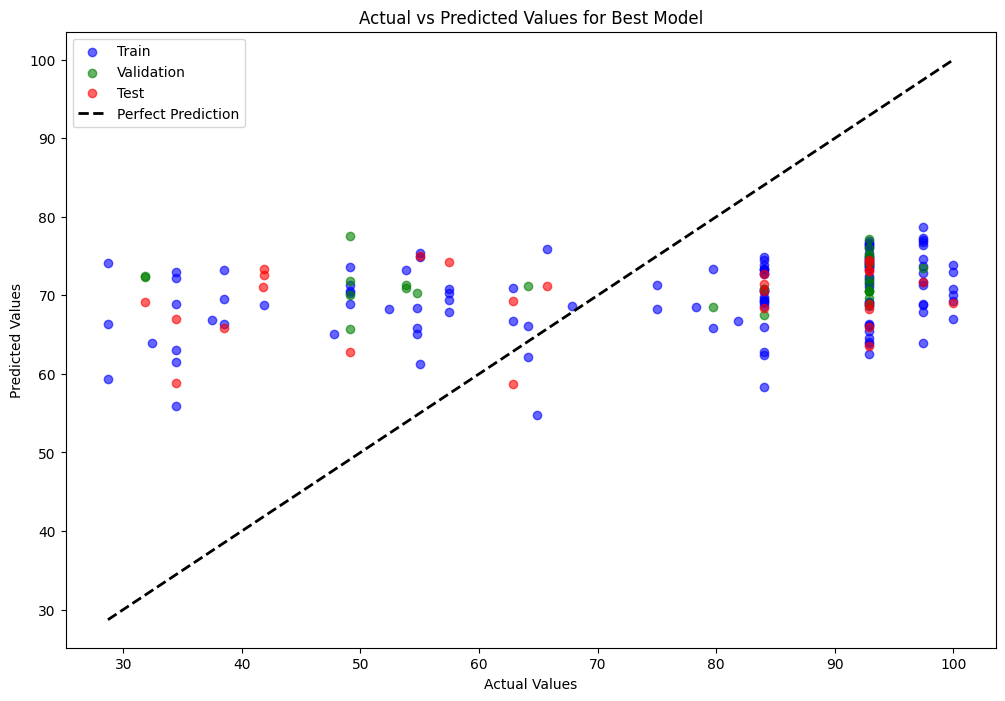

In [22]:
#2--------------------------------------------------NN Hyperparameter tuning
X_val, X_test, y_val, y_test = train_test_split(xtest, ytest, test_size=0.5, random_state=42)

# Define hyperparameter ranges
learning_rates = [0.1, 0.01, 0.001]
activation_functions = ['relu', 'tanh', 'leaky_relu']
num_layers_options = [1, 2, 3]
results = []

# Define a function to build the model
def build_model(layers, activation, learning_rate):
    model = Sequential()
    model.add(Input(shape=(xtrain.shape[1],)))
    for _ in range(layers):
        model.add(Dense(units=128, activation=activation))
    model.add(Dense(1))  # Output layer for regression
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    return model

# Train and evaluate all combinations
for activation, lr, layers in itertools.product(activation_functions, learning_rates, num_layers_options):
    model = build_model(layers, activation, lr)
    history = model.fit(
        xtrain, ytrain,
        epochs=300,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
        verbose=0
    )
    y_pred_test = model.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)
    results.append({
        'activation': activation,
        'learning_rate': lr,
        'num_layers': layers,
        'r2_score': r2
    })

# Organize results into a table
results_df = pd.DataFrame(results)
pivot_table = results_df.pivot_table(
    index='activation',
    columns=['learning_rate', 'num_layers'],
    values='r2_score'
)
print("\nR2 Scores Table:")
print(pivot_table)

# Find the best combination
best_row = results_df.loc[results_df['r2_score'].idxmax()]
print("\nBest Hyperparameter Combination:")
print(best_row)

# Plot Actual vs Predicted for the best combination
best_model = build_model(
    best_row['num_layers'],
    best_row['activation'],
    best_row['learning_rate']
)

# Fit the best model with training data
best_model.fit(
    xtrain, ytrain,  # Correcting to use ytrain for training
    epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=0
)

# Predictions for the best model
y_pred_train = best_model.predict(xtrain)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.scatter(ytrain, y_pred_train, color='blue', alpha=0.6, label='Train')
plt.scatter(y_val, y_pred_val, color='green', alpha=0.6, label='Validation')
plt.scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', color='black', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Best Model")
plt.legend()
plt.show()


In [14]:


#3----------------------------------------------------XGBoost

xgb_model = XGBRegressor(
    n_estimators=150,  # Number of trees
    learning_rate=0.1,  # Learning rate (eta)
    random_state=42,  # Ensures reproducibility
    max_depth=9,  # Maximum depth of trees
    subsample=0.8,  # Fraction of samples used for fitting
    colsample_bytree=0.8  # Fraction of features considered per tree
)
xgb_model.fit(xtrain, ytrain)

# Predict and Evaluate
xgb_y_pred = xgb_model.predict(xtest)
xgb_mse = mean_squared_error(ytest, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(ytest, xgb_y_pred)
xgb_r2 = r2_score(ytest, xgb_y_pred)

# Print Metrics
print(f"XGBoost MSE: {xgb_mse:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")
print(f"XGBoost R²: {xgb_r2:.4f}")




XGBoost MSE: 512.9684
XGBoost RMSE: 22.6488
XGBoost MAE: 18.2759
XGBoost R²: 0.0146


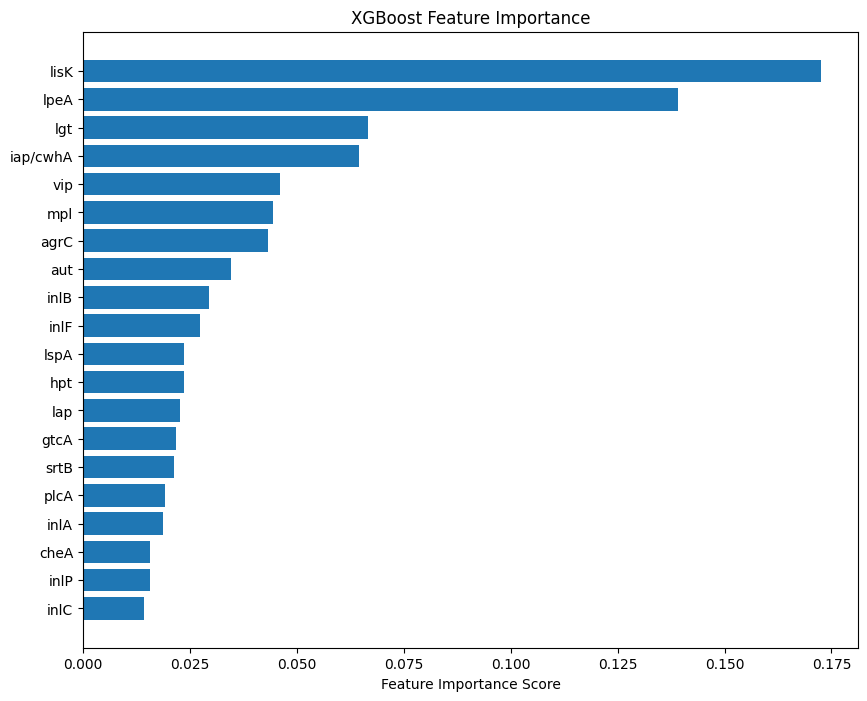

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
    Num Features  \
0              1   
1              2   
2              3   
3              4   
4              5   
5              6   
6              7   
7              8   
8              9   
9             10   
10            11   
11            12   
12            13   
13            14   
14            15   
15            16   
16            17   
17            18   
18            19   
19            20   
20            21   
21            22   
22            23   
23            24   
24            25   
25            26   
26            27   
27            28   
28            29   
29            30   
30            31   
31            32   
32            33   
33            34   
34            35   
35            36   
36            37   
37            38   
38            39   
39            40   
40            41   
41            42   
42            43   
43            44   
44            45   

                                         

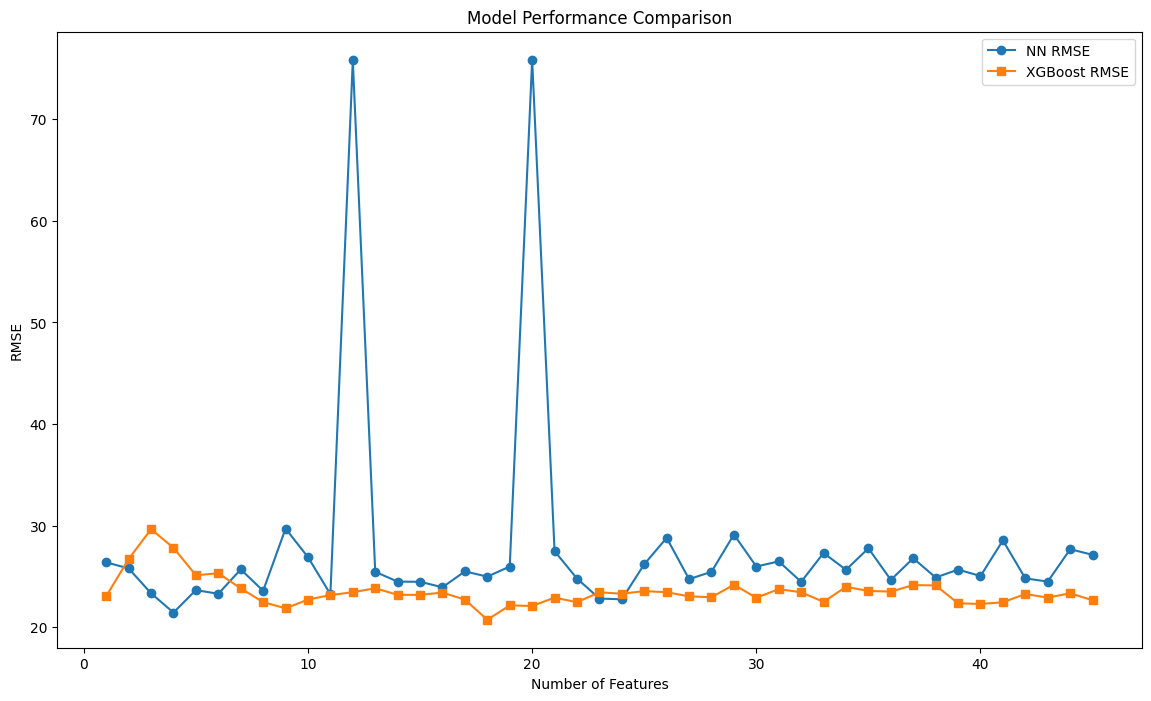

In [20]:
#4----------------------------------------------------XGBoost VS NN
feature_names = X.columns.tolist()

# ---- XGBoost Feature Importance ----
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(xtrain, ytrain)

# Get Feature Importance and Sort
xgb_importances = xgb_model.feature_importances_
sorted_indices = np.argsort(xgb_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot Feature Importance with Feature Names
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names[:20][::-1], xgb_importances[sorted_indices[:20][::-1]])
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.show()

# Initialize Results Storage
results = []

#  Train Models Using Features in Descending Importance
for num_features in range(1, len(sorted_feature_names) + 1):
    # Select Top Features
    top_features = sorted_indices[:num_features]
    X_train_subset = xtrain[:, top_features]
    X_test_subset = xtest[:, top_features]

    # ---- Neural Network ----
    nn_model = Sequential([
        Dense(128, input_dim=X_train_subset.shape[1]),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        Dropout(0.3),
        Dense(160),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        Dropout(0.3),
        Dense(96),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='huber',
                     metrics=['mean_squared_error'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    nn_model.fit(X_train_subset, ytrain,
                 epochs=100,
                 batch_size=16,
                 validation_split=0.2,
                 callbacks=[early_stopping],
                 verbose=0)

    nn_y_pred = nn_model.predict(X_test_subset).flatten()
    nn_mse = mean_squared_error(ytest, nn_y_pred)
    nn_rmse = np.sqrt(nn_mse)
    nn_mae = mean_absolute_error(ytest, nn_y_pred)
    nn_r2 = r2_score(ytest, nn_y_pred)

    # ---- XGBoost ----
    xgb_model = XGBRegressor(
        n_estimators=150,
        learning_rate=0.1,
        random_state=42,
        max_depth=9,
        subsample=0.8,
        colsample_bytree=0.8
    )
    xgb_model.fit(X_train_subset, ytrain)

    xgb_y_pred = xgb_model.predict(X_test_subset)
    xgb_mse = mean_squared_error(ytest, xgb_y_pred)
    xgb_rmse = np.sqrt(xgb_mse)
    xgb_mae = mean_absolute_error(ytest, xgb_y_pred)
    xgb_r2 = r2_score(ytest, xgb_y_pred)

    # Store Results
    results.append({
        'Num Features': num_features,
        'Top Features': ', '.join(sorted_feature_names[:num_features]),
        'NN MSE': nn_mse, 'NN RMSE': nn_rmse, 'NN MAE': nn_mae, 'NN R²': nn_r2,
        'XGB MSE': xgb_mse, 'XGB RMSE': xgb_rmse, 'XGB MAE': xgb_mae, 'XGB R²': xgb_r2
    })

# Convert Results to DataFrame
results_df = pd.DataFrame(results)

# Display Results
pd.set_option('display.max_colwidth', None)  # Ensure feature names are fully displayed
print(results_df)

# Plot Performance Metrics
plt.figure(figsize=(14, 8))
plt.plot(results_df['Num Features'], results_df['NN RMSE'], label='NN RMSE', marker='o')
plt.plot(results_df['Num Features'], results_df['XGB RMSE'], label='XGBoost RMSE', marker='s')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

